# Seurat

In [1]:
suppressPackageStartupMessages({
    library(Matrix)
    library(scater)
    library(Seurat)
    library(topGO)
    library(data.table)
    library(cowplot)
})

Warning message:
“replacing previous import ‘BiocGenerics::dims’ by ‘Biobase::dims’ when loading ‘SummarizedExperiment’”Warning message:
“replacing previous import ‘Biobase::dims’ by ‘DelayedArray::dims’ when loading ‘SummarizedExperiment’”Warning message:
“replacing previous import ‘BiocGenerics::dims’ by ‘Biobase::dims’ when loading ‘AnnotationDbi’”Warning message:
“replacing previous import ‘BiocGenerics::dims’ by ‘Biobase::dims’ when loading ‘topGO’”
groupGOTerms: 	GOBPTerm, GOMFTerm, GOCCTerm environments built.


In [2]:
# dir.create("2.Seurat")
setwd("./2.Seurat/")

**This pipeline is a direct continuation of the `scater` workflow.** Start by loading in the sparse matrix .Rds file containing the quality-controlled, filtered matrix generated in the `scater` notebook.

In [6]:
sceMGP <- readRDS(file = "../1.scater/mouse.growth.plate_QCfiltered.Rds")
dim(sceMGP)

[1] 22893   186

Convert the `SingleCellExperiment` object to a `Seurat` object.

In [7]:
# mGP <- Convert(from = sceMGP, to = "seurat", project = "mouse growth plate")
mGP <- as.Seurat(sceMGP, counts = "counts", data = "logcounts")
mGP

An object of class Seurat 
22893 features across 186 samples within 1 assay 
Active assay: RNA (22893 features)
 1 dimensional reduction calculated: PCA_coldata

## Data preprocessing

### Import and append metadata

In [11]:
metadata <- read.table(file = "../metadata/metadata.tsv",
                       sep = "\t", row.names = 1)
colnames(metadata) <- c("Organism")
head(metadata, 3)

,Organism
,<fct>
SRR3032925,Mouse
SRR3032926,Mouse
SRR3032927,Mouse


In [12]:
mGP <- AddMetaData(mGP, metadata = metadata)

In [13]:
mGP@meta.data[1:3,1:5]

,Cells,Organism,is_cell_control,total_features_by_counts,log10_total_features_by_counts
,<chr>,<fct>,<lgl>,<int>,<dbl>
SRR3032925,SRR3032926,Mouse,FALSE,3403,3.531990
SRR3032926,SRR3032927,Mouse,FALSE,3602,3.556664
SRR3032927,SRR3032928,Mouse,FALSE,5104,3.707996


## Normalization

Perform standard log-normalisation with a scale factor of $10^{4}$.

In [14]:
mGP <- NormalizeData(object = mGP,
                     normalization.method = "LogNormalize",
                     scale.factor = 10000)

`FindVariableGenes` calculates the variance and mean for each gene in the dataset (stored in `object@hvg.info`) and sorts genes by their variance/mean ratio (VMR).

In [18]:
mGP <- FindVariableFeatures(object = mGP, mean.function = ExpMean, dispersion.function = LogVMR)

In [19]:
length(VariableFeatures(mGP))

[1] 2000

For downstream analysis, the 2000 most variable genes are selected.

## Regressing out latent variables

### Scaling the data based on %Mito and nUMI

In [20]:
mito.genes <- grep(pattern = "mt-", x = rownames(x = GetAssayData(object = mGP)), value = TRUE)
percent.mito <- Matrix::colSums(GetAssayData(object = mGP)[mito.genes, ])/Matrix::colSums(GetAssayData(object = mGP, slot = "counts")) * 100

In [21]:
mGP <- AddMetaData(object = mGP,
                   metadata = percent.mito,
                   col.name = "percent.mito")

We regress out the latent variables, defined as the number of UMIs and the percentage of mitochondrial reads per cell using both a linear regression model and a negative binomial model. The best performing method is then selected for the downstream analysis.

In [24]:
all.genes <- rownames(mGP)

In [25]:
# Linear regression model
mGP.lin <- ScaleData(mGP, features = all.genes, vars.to.regress = c("percent.mito", "nCount_RNA"))

Regressing out percent.mito, nCount_RNA
Centering and scaling data matrix


In [26]:
mGP.negbinom <- ScaleData(mGP, features = all.genes, vars.to.regress = c("percent.mito", "nCount_RNA"),
                          model.use = "negbinom")

Regressing out percent.mito, nCount_RNA
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message:
“glm.fit: algorithm did not converge”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxi

### Dimensionality reduction

In [28]:
mGP.lin <- RunPCA(object = mGP.lin, pc.genes = VariableFeatures(object = mGP))
mGP.negbinom <- RunPCA(object = mGP.negbinom, pc.genes = VariableFeatures(object = mGP))

PC_ 1 
Positive:  Exo1, Cxcl5, Gm42479, 1700029H14Rik, Iqcf3, Retreg3, Svopl, Aldh1a2, Evc, Mfsd4b3 
	   Hgf, Igf1, Gm4978, Gm48408, Prox1, Ntrk3, Ccdc122, Ppp1r1a, Helz2, Arhgap11a 
	   Shcbp1, Gm42443, Dnm3, Foxp1, Trpm3, Top2a, Neil3, Zfp316, Gm42432, Abi3bp 
Negative:  Serinc5, Cdkn1c, Trps1, Tent5a, Lpar1, Slc26a2, Pmp22, Myadm, Enc1, Chad 
	   Scd1, Gna12, Samhd1, Atp2b1, Cd24a, Alpl, Lcp1, Slc23a2, Limd1, Cercam 
	   Id2, Sox5, Uba5, Gm43188, Tshz1, Vamp7, Pmm2, Golim4, Ehd2, Timp3 
PC_ 2 
Positive:  Exo1, Incenp, Sox9, Neil3, Arhgap11a, Svopl, 1700029H14Rik, Spc24, Gm42479, Cxcl5 
	   Iqcf3, Atad2, Aldh1a2, Evc, Top2a, Gm4978, Helz2, Mcm10, Gm48408, Mfsd4b3 
	   Hgf, Igf1, Ptges, Ntrk3, Ccdc122, Ppp1r1a, Prox1, Gm42443, Pbk, Eln 
Negative:  Atp13a5, Ccno, Fbxo47, 4930459C07Rik, Zfp658, Gm6994, Mepe, Gm37168, Cyp1a1, 4930594C11Rik 
	   Depp1, Gm38384, Spata13, Steap4, 4933415A04Rik, Zbtb14, Ripor2, Gpr176, Cp, Fgf7 
	   Fam107b, Lrrc4, AC103947.2, Pde11a, Pank1, Adgrl2, Clu, Tci

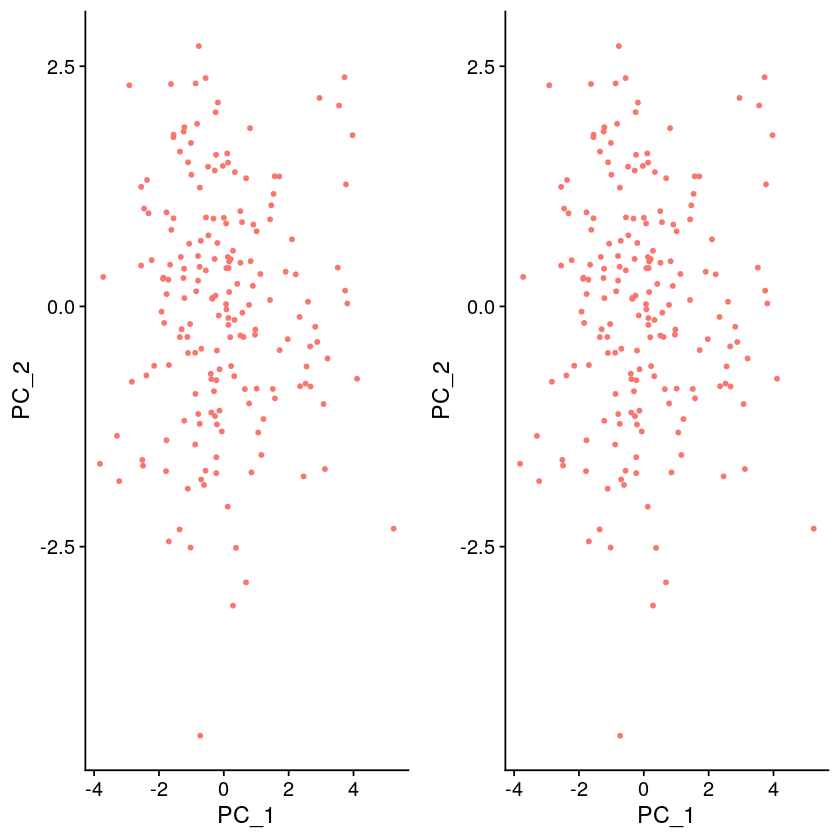

In [29]:
PCA.lin <- DimPlot(mGP.lin) + NoLegend()
PCA.negbinom <- DimPlot(mGP.negbinom) + NoLegend()
plot_grid(PCA.lin, PCA.negbinom)

### The cell cycle

The cell cycle is a potential, hidden source of heterogeneity in single-cell transcriptome data. The classic method to regress out mitosis-related heterogeneity removes all signal associated to the cell cycle. However, in some cases this can negatively impact downstream analysis, particularly in differentiation processes, where stem cells are quiescent and differentiated cells are proliferating (or vice versa). In this case, regressing out all cell cycle effects can blur the distinction between stem and progenitor cells as well.

As an alternative, Satija *et al.* suggest regressing out the difference between **the G2M and S phase scores**. This means that signals separating non-cycling cells and cycling cells will be maintained, but differences in cell cycle phase amongst proliferating cells (which are often uninteresting), will be regressed out of the data.

Considering that the nature of the growth plate is one of both proliferation as well as concommitant differentiation, this approach appears to be the most suitable. However, because there might not be a real downstream effect, we will compare the PCAs of the data scaled by UMI and %Mito with PCAs on the data scaled by UMI, %Mito and cell cycle.

In [30]:
mouse.cc.genes <- readRDS(file = "/mnt/c/Users/u0124158/Documents/NGS/DebnathPSC/1.4.Seurat/mouse_cell_cycle_genes.Rds")

#### Assign cell cycle scores

First we assign each cell a score based on its expression of G2/M and S phase markers. These marker sets should be anticorrelated in their expression levels. Cells expressing neither are likely not cycling and in G1 phase.

We assign cscores in the `CellCycleScoring` function, which stores S and G2/M scores in object metadata, along with the predicted classification of each cell in either G1, S or G2/M phase. `CellCycleScoring` can also set the identity of the Seurat object to the cell-cycle phase by passing `set.ident = TRUE`. The original identities are then stored in `old.ident`. Note that Seurat does not use the discrete classifications (G1, S, G2/M) in downstream cell cycle regression. Instead, it uses the quantitative scores for G2/M and S phase.

In [32]:
s.genes <- mouse.cc.genes$s.genes
g2m.genes <- mouse.cc.genes$g2m.genes

In [33]:
mGP.cc.lin <- CellCycleScoring(mGP.lin, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
head(mGP.cc.lin@meta.data[,c(1:4,44:46)])

,Cells,Organism,is_cell_control,total_features_by_counts,G2M.Score,Phase,old.ident
,<chr>,<fct>,<lgl>,<int>,<dbl>,<fct>,<fct>
SRR3032925,SRR3032926,Mouse,FALSE,3403,-0.0776505493,S,SingleCellExperiment
SRR3032926,SRR3032927,Mouse,FALSE,3602,-0.0357013691,G1,SingleCellExperiment
SRR3032927,SRR3032928,Mouse,FALSE,5104,-0.0001086894,S,SingleCellExperiment
SRR3032928,SRR3032929,Mouse,FALSE,4109,0.0528422352,G2M,SingleCellExperiment
SRR3032929,SRR3032930,Mouse,FALSE,3726,-0.0732899957,G1,SingleCellExperiment
SRR3032930,SRR3032931,Mouse,FALSE,5477,0.3221621681,S,SingleCellExperiment


In [34]:
mGP.cc.negbinom <- CellCycleScoring(mGP.negbinom, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
head(mGP.cc.negbinom@meta.data[,c(1:4,44:46)])

,Cells,Organism,is_cell_control,total_features_by_counts,G2M.Score,Phase,old.ident
,<chr>,<fct>,<lgl>,<int>,<dbl>,<fct>,<fct>
SRR3032925,SRR3032926,Mouse,FALSE,3403,-0.0776505493,S,SingleCellExperiment
SRR3032926,SRR3032927,Mouse,FALSE,3602,-0.0357013691,G1,SingleCellExperiment
SRR3032927,SRR3032928,Mouse,FALSE,5104,-0.0001086894,S,SingleCellExperiment
SRR3032928,SRR3032929,Mouse,FALSE,4109,0.0528422352,G2M,SingleCellExperiment
SRR3032929,SRR3032930,Mouse,FALSE,3726,-0.0732899957,G1,SingleCellExperiment
SRR3032930,SRR3032931,Mouse,FALSE,5477,0.3221621681,S,SingleCellExperiment


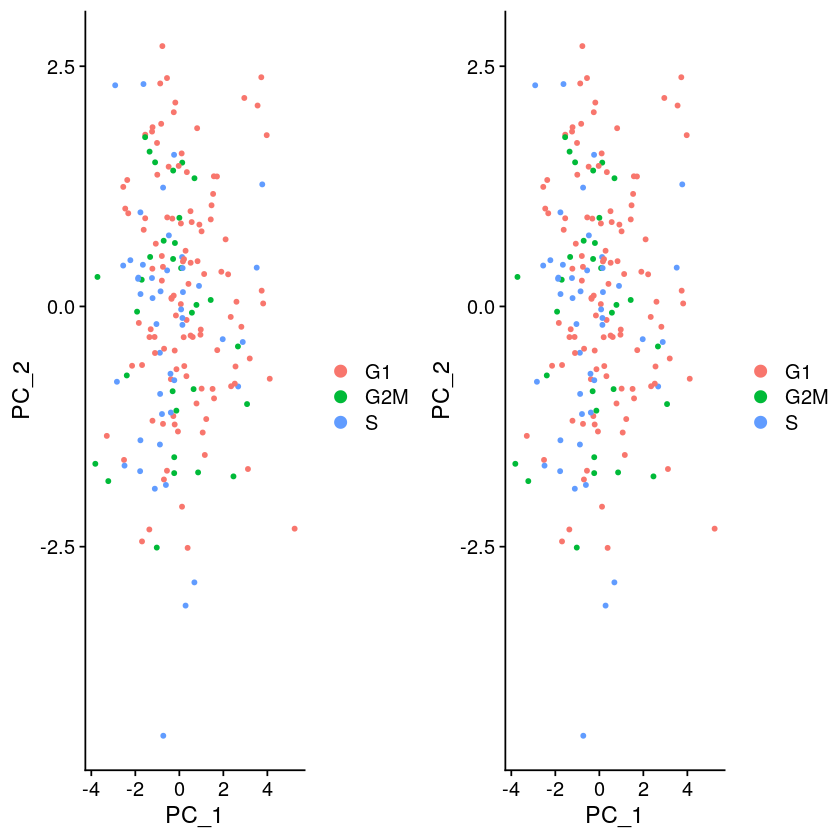

In [35]:
PCA.cc.lin <- DimPlot(mGP.cc.lin)
PCA.cc.negbinom <- DimPlot(mGP.cc.negbinom)

plot_grid(PCA.cc.lin, PCA.cc.negbinom)

There does not appear to be any major effect of the cell cycle as a source of heterogeneity. Therefore, I will not regress out based on the cell cycle.

For each gene, Seurat models the relationship between gene expression and the S and G2M cell cycle scores. The scaled residuals of this model represent a 'corrected' expression matrix, that can be used downstream for dimensional reduction.

As mentioned above, regressing out by **difference** between G2/M and S phase scores (instead of by G2/M and S phase scores) will preserve the separation between cycling and non-cycling cells. Differences between the cell cycle phase amongst proliferating cells will be regressed out, as they are noisy and not interesting.

Lets replace the original `Seuratobject` with the model scaled to the negative binomial distribution, regressing out nUMI and %Mito.

In [36]:
mGP <- mGP.negbinom

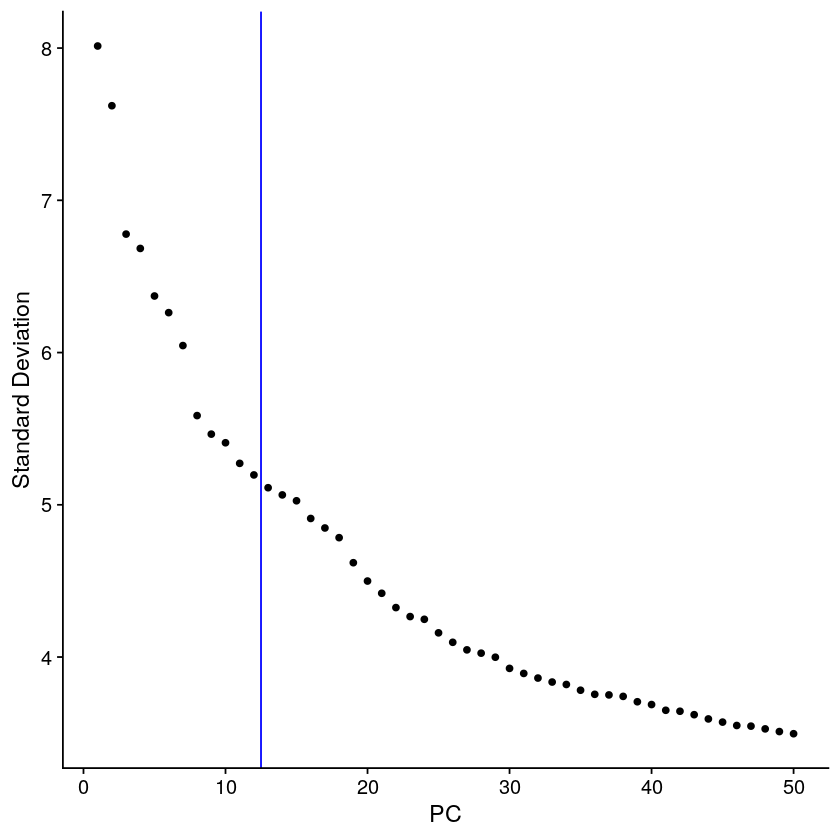

In [39]:
ElbowPlot(object = mGP, ndims = 50) + geom_vline(xintercept = 12.5, color = "blue")

In [40]:
mGP <- FindNeighbors(object = mGP, dims = 1:12)
mGP <- FindClusters(object = mGP, reduction = "pca", resolution = 1)

Computing nearest neighbor graph
Computing SNN
Warning message:
“The following arguments are not used: reduction”Warning message:
“The following arguments are not used: reduction”

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 186
Number of edges: 7054

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4375
Number of communities: 3
Elapsed time: 0 seconds


In [41]:
mGP <- RunTSNE(object = mGP, reduction = "pca", dims = 1:12)

The following functions and any applicable methods accept the dots: CombinePlots


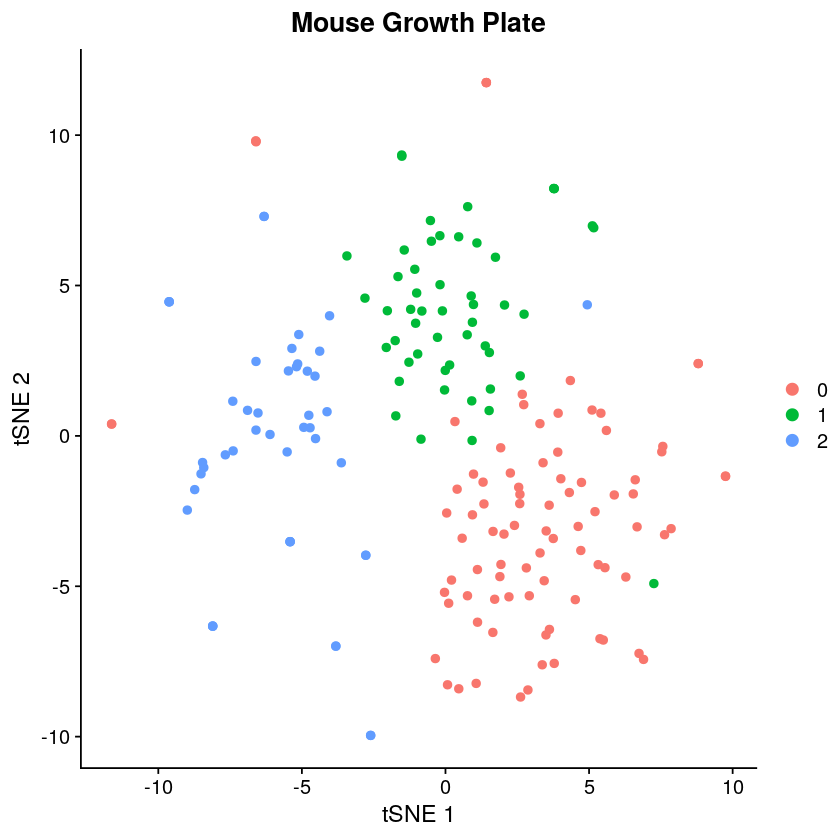

In [44]:
DimPlot(object = mGP, reduction = "tsne", no.legend = FALSE, 
        do.return = TRUE, vector.friendly = TRUE, pt.size = 2) + 
    ggtitle("Mouse Growth Plate") + xlab("tSNE 1") + ylab("tSNE 2") + 
    theme(plot.title = element_text(hjust = 0.5))

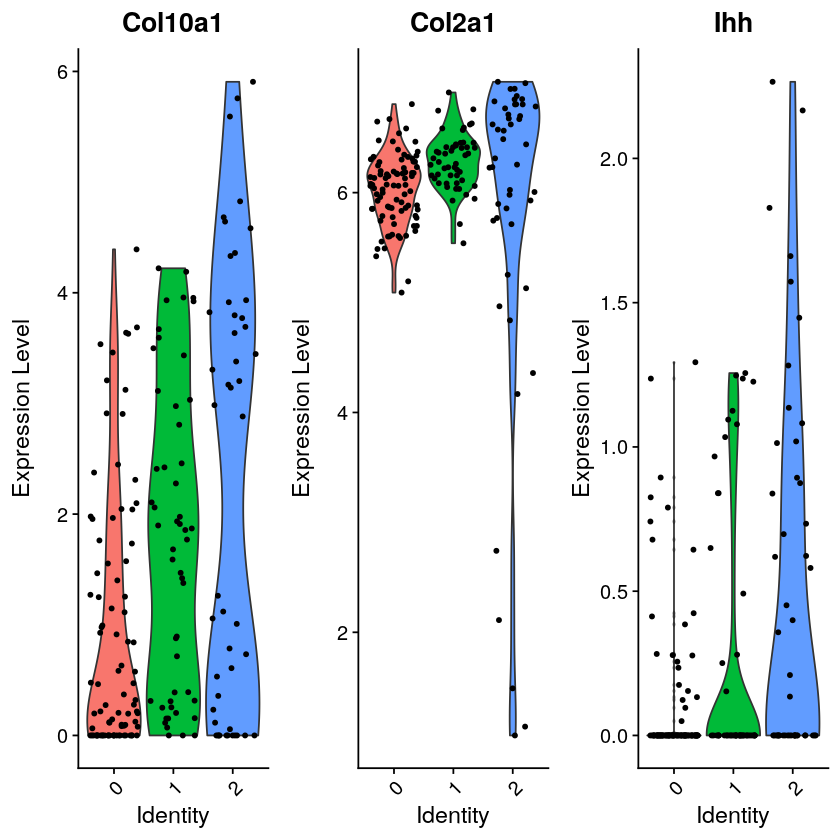

In [45]:
VlnPlot(mGP, features = c("Col10a1", "Col2a1", "Ihh"))

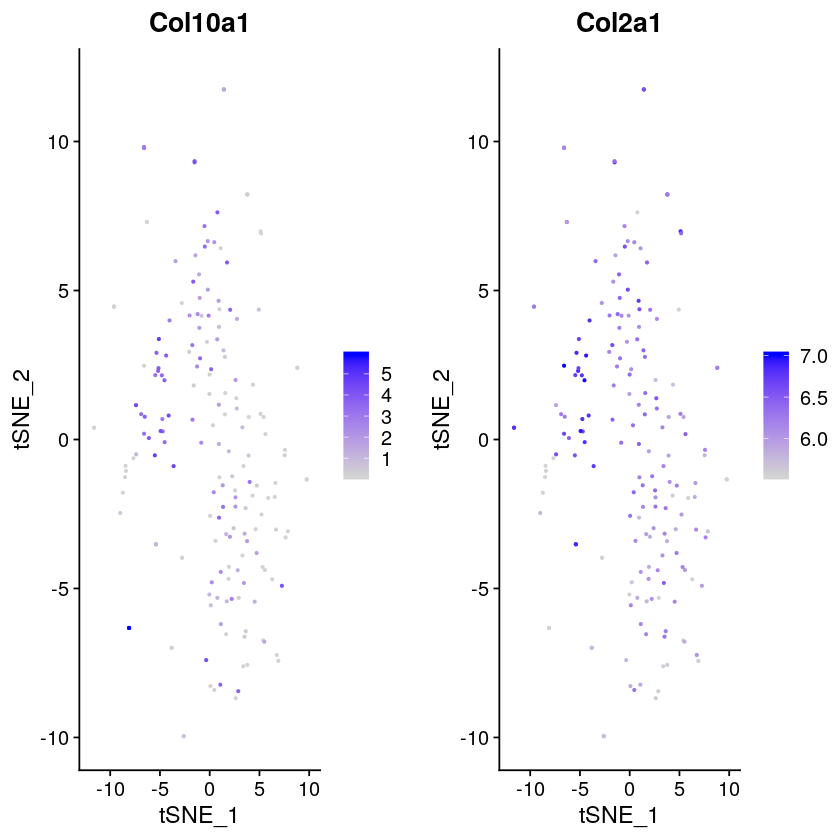

In [47]:
FeaturePlot(object = mGP, features = c("Col10a1", "Col2a1"), reduction = "tsne",
            min.cutoff = "q9", cols = c("lightgrey", "blue"), pt.size = 0.5)

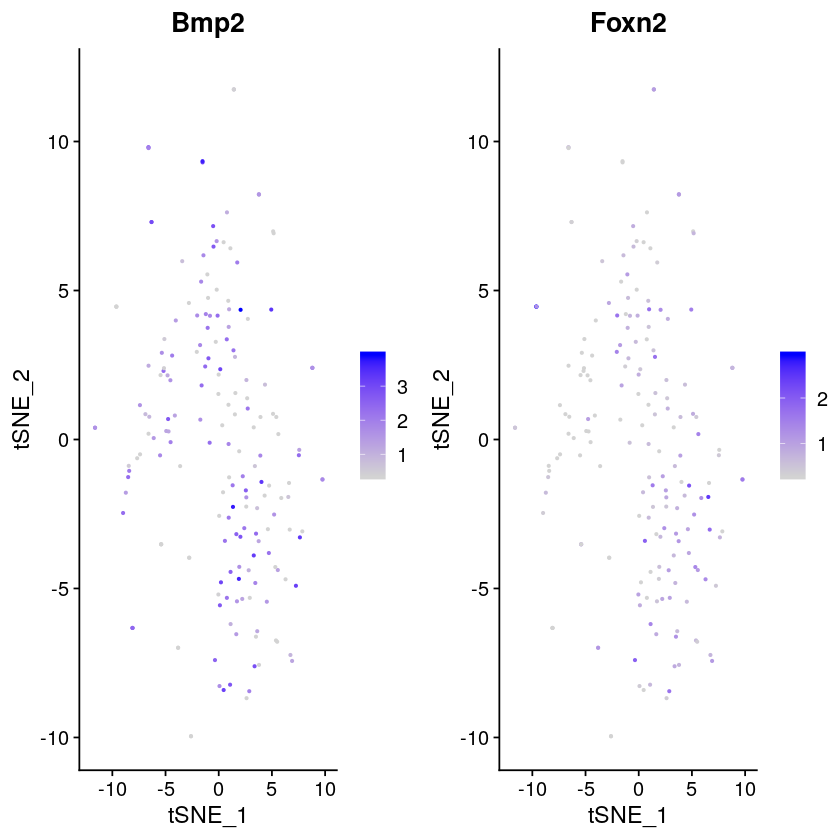

In [48]:
FeaturePlot(object = mGP, features = c("Bmp2", "Foxn2"), reduction = "tsne",
            min.cutoff = "q9", cols = c("lightgrey", "blue"), pt.size = 0.5)

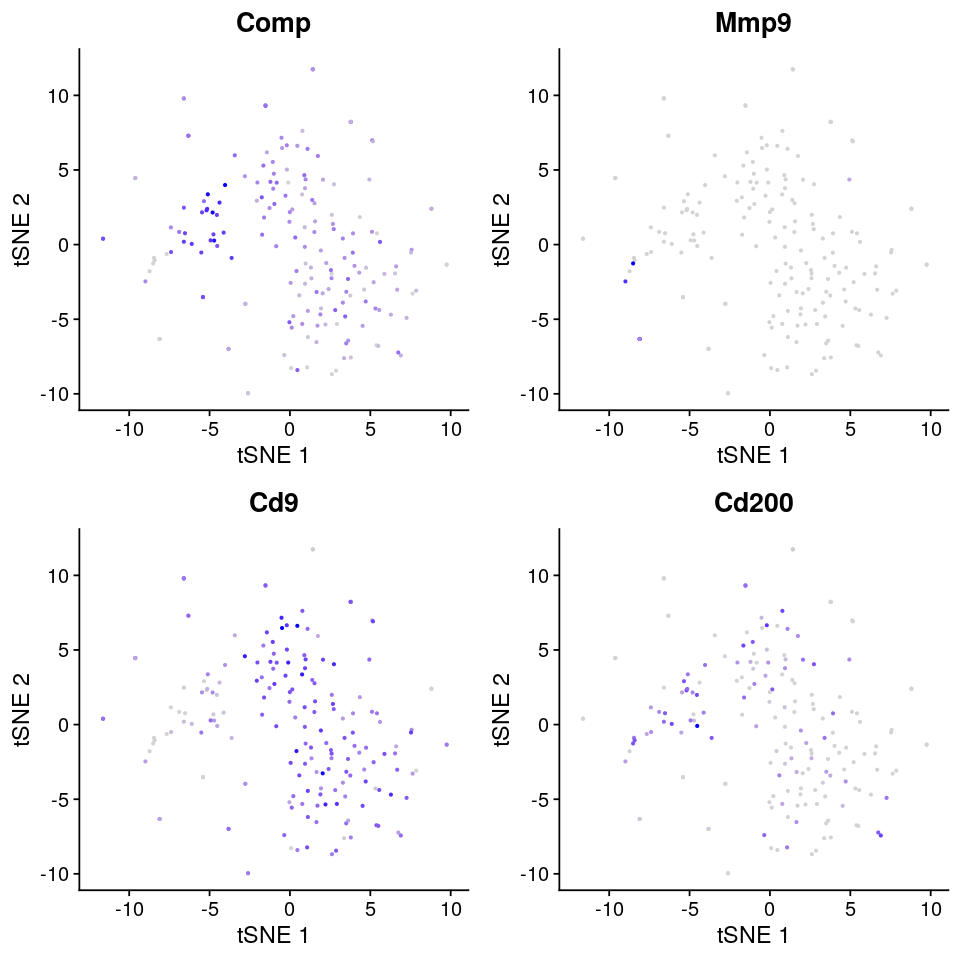

In [52]:
plots <- FeaturePlot(object = mGP, features = c("Comp", "Mmp9", "Cd9", "Cd200"), reduction = "tsne",
                     min.cutoff = "q9", cols = c("lightgrey", "blue"), pt.size = 0.5, combine = FALSE)
plots <- lapply(X = plots, FUN = function(p) p + xlab("tSNE 1") + ylab("tSNE 2") + theme(legend.position = "none"))
CombinePlots(plots = plots)

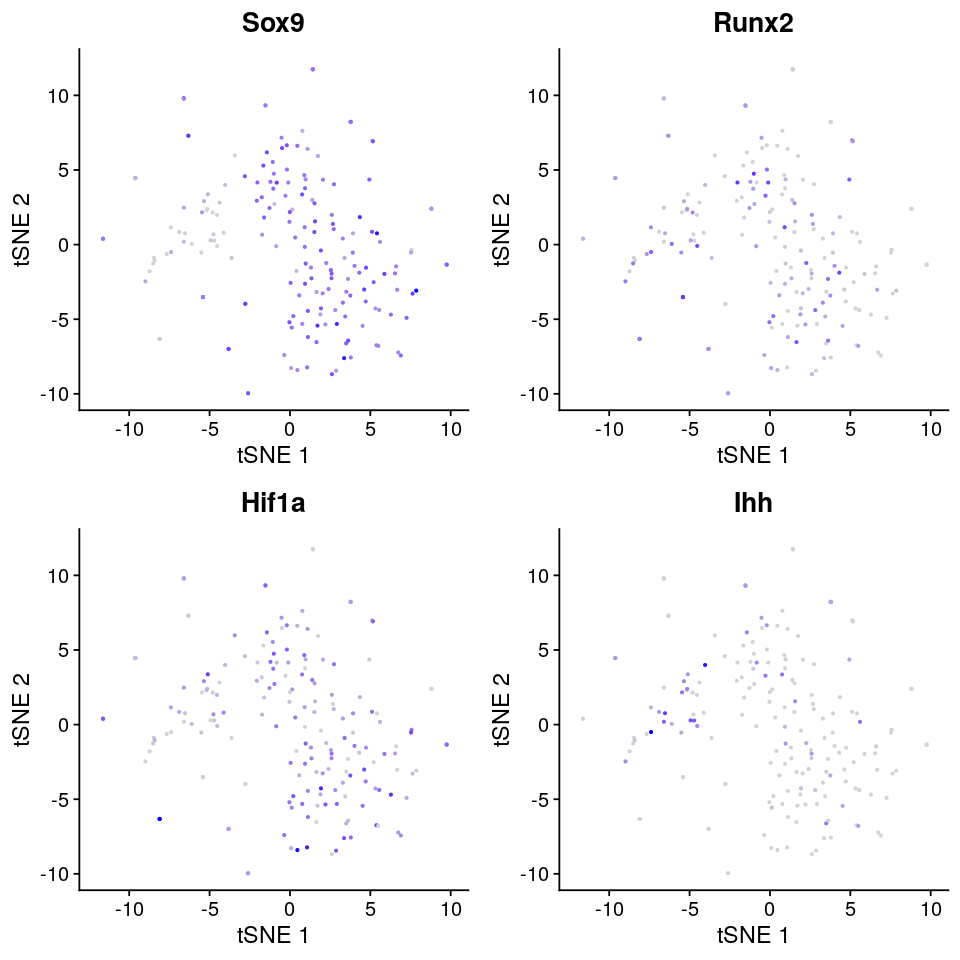

In [54]:
plots <- FeaturePlot(object = mGP, features = c("Sox9", "Runx2", "Hif1a", "Ihh"), reduction = "tsne",
                     min.cutoff = "q9", cols = c("lightgrey", "blue"), pt.size = 0.5, combine = FALSE)
plots <- lapply(X = plots, FUN = function(p) p + xlab("tSNE 1") + ylab("tSNE 2") + theme(legend.position = "none"))
CombinePlots(plots = plots)

In [55]:
saveRDS(mGP, file = "mGP.SeuratObject.Rds")

In [64]:
new.cluster.ids <- c("Proliferative chondrocyte", "Prehypertrophic chondrocyte", "Hypertrophic chondrocyte")
names(new.cluster.ids) <- levels(mGP)
mGP <- RenameIdents(mGP, new.cluster.ids)

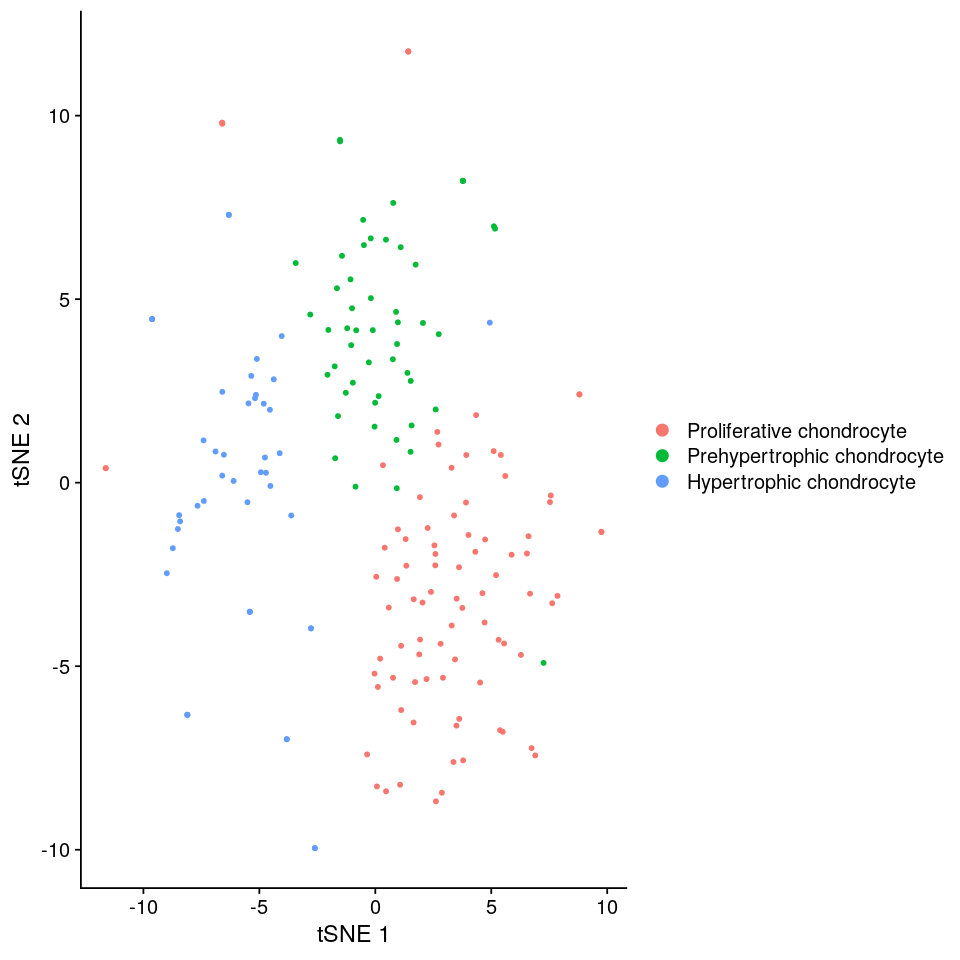

In [65]:
DimPlot(mGP, reduction = "tsne") + xlab("tSNE 1") + ylab("tSNE 2")

In [66]:
write.table(Idents(object = mGP), file = "./cell.idents.tsv", sep = "\t", quote = FALSE, row.names = TRUE)

In [67]:
saveRDS(mGP, file = "./mGP_Li_v3.SeuratObject.Rds")

In [3]:
library(Seurat)
setwd("./2.Seurat/")

mGP.Li <- readRDS(file = "./mGP_Li_v3.SeuratObject.Rds")

### Exporting the count matrix

In [68]:
raw.counts <- GetAssayData(object = mGP, slot = "counts")
raw.counts[1:5, 1:5]

write.table(raw.counts, file = "./mouse_growthPlate.raw_counts.txt", quote = FALSE, sep = "\t")

5 x 5 sparse Matrix of class "dgCMatrix"
              SRR3032925 SRR3032926 SRR3032927 SRR3032928 SRR3032929
0610009B22Rik          .          .          .          2          3
0610009E02Rik          .          .          .          .          .
0610009L18Rik          .          .          .          .          .
0610010F05Rik          .          .          .          .          1
0610010K14Rik          1          .          .          .          .

In [69]:
normalized.counts <- GetAssayData(object = mGP, slot = "scale.data")
normalized.counts[1:5, 1:5]

write.table(normalized.counts, file = "./mouse_growthPlate.normalized_counts.txt", quote = FALSE, sep = "\t")

,SRR3032925,SRR3032926,SRR3032927,SRR3032928,SRR3032929
0610009B22Rik,-0.5621045,-0.5771704,-0.60609359,1.0367308,1.9545793
0610009E02Rik,-0.1880626,-0.1803274,-0.25365463,-0.1969589,-0.1913968
0610009L18Rik,-0.1831596,-0.2035975,0.04469974,-0.1363759,-0.1778307
0610010F05Rik,-0.3967979,-0.4055880,-0.41724293,-0.4091297,0.7053001
0610010K14Rik,9.2541301,-0.7094138,0.12040629,-0.3833691,-0.2019173


In [5]:
saveRDS(GetAssayData(mGP.Li, slot = "counts"), file = "Li_rawdata.Rds")

In [10]:
Identity <- Idents(mGP.Li)
IdentityDF <- as.data.frame(Identity)
mGP.Li <- AddMetaData(mGP.Li, IdentityDF)
head(mGP.Li@meta.data)

,Cells,Organism,is_cell_control,total_features_by_counts,log10_total_features_by_counts,total_counts,log10_total_counts,pct_counts_in_top_50_features,pct_counts_in_top_100_features,pct_counts_in_top_200_features,⋯,pct_counts_in_top_100_features_Mt,pct_counts_in_top_200_features_Mt,pct_counts_in_top_500_features_Mt,outlier,nCount_RNA,nFeature_RNA,percent.mito,RNA_snn_res.1,seurat_clusters,Identity
,<chr>,<fct>,<lgl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<int>,<dbl>,<fct>,<fct>,<fct>
SRR3032925,SRR3032926,Mouse,FALSE,3403,3.531990,42815,4.631606,28.00654,36.96602,48.29149,⋯,100,100,100,FALSE,42815,3403,0.05732117,0,0,Proliferative chondrocyte
SRR3032926,SRR3032927,Mouse,FALSE,3602,3.556664,41527,4.618341,34.61362,42.64936,52.46225,⋯,100,100,100,FALSE,41527,3602,0.04894051,0,0,Proliferative chondrocyte
SRR3032927,SRR3032928,Mouse,FALSE,5104,3.707996,103841,5.016373,32.16263,40.58609,50.50799,⋯,100,100,100,FALSE,103841,5104,0.02437128,1,1,Prehypertrophic chondrocyte
SRR3032928,SRR3032929,Mouse,FALSE,4109,3.613842,54578,4.737026,31.34413,39.51409,49.33306,⋯,100,100,100,FALSE,54578,4109,0.04286984,0,0,Proliferative chondrocyte
SRR3032929,SRR3032930,Mouse,FALSE,3726,3.571359,42041,4.623683,32.66335,41.45239,51.36890,⋯,100,100,100,FALSE,42041,3726,0.06416622,1,1,Prehypertrophic chondrocyte
SRR3032930,SRR3032931,Mouse,FALSE,5477,3.738622,104259,5.018118,25.78291,33.68822,43.42839,⋯,100,100,100,FALSE,104259,5477,0.02124263,2,2,Hypertrophic chondrocyte


In [11]:
colnames(mGP.Li@meta.data)

[1] "Cells"                                         
 [2] "Organism"                                      
 [3] "is_cell_control"                               
 [4] "total_features_by_counts"                      
 [5] "log10_total_features_by_counts"                
 [6] "total_counts"                                  
 [7] "log10_total_counts"                            
 [8] "pct_counts_in_top_50_features"                 
 [9] "pct_counts_in_top_100_features"                
[10] "pct_counts_in_top_200_features"                
[11] "pct_counts_in_top_500_features"                
[12] "total_features_by_counts_endogenous"           
[13] "log10_total_features_by_counts_endogenous"     
[14] "total_counts_endogenous"                       
[15] "log10_total_counts_endogenous"                 
[16] "pct_counts_endogenous"                         
[17] "pct_counts_in_top_50_features_endogenous"      
[18] "pct_counts_in_top_100_features_endogenous"     
[19] "pct_counts_in_top_200_features_endogenous"     
[20] "pct_counts_in_top_500_features_endogenous"     
[21] "total_features_by_counts_feature_control"      
[22] "log10_total_features_by_counts_feature_control"
[23] "total_counts_feature_control"                  
[24] "log10_total_counts_feature_control"            
[25] "pct_counts_feature_control"                    
[26] "pct_counts_in_top_50_features_feature_control" 
[27] "pct_counts_in_top_100_features_feature_control"
[28] "pct_counts_in_top_200_features_feature_control"
[29] "pct_counts_in_top_500_features_feature_control"
[30] "total_features_by_counts_Mt"                   
[31] "log10_total_features_by_counts_Mt"             
[32] "total_counts_Mt"                               
[33] "log10_total_counts_Mt"                         
[34] "pct_counts_Mt"                                 
[35] "pct_counts_in_top_50_features_Mt"              
[36] "pct_counts_in_top_100_features_Mt"             
[37] "pct_counts_in_top_200_features_Mt"             
[38] "pct_counts_in_top_500_features_Mt"             
[39] "outlier"                                       
[40] "nCount_RNA"                                    
[41] "nFeature_RNA"                                  
[42] "percent.mito"                                  
[43] "RNA_snn_res.1"                                 
[44] "seurat_clusters"                               
[45] "Identity"

In [14]:
metadata <- mGP.Li@meta.data[, c(2,45)]
metadata$Origin <- "Growth plate"
metadata$CellType <- "Chondrocyte"
metadata$DevTP <- "P7"
metadata$Author <- "Li"
metadata$Tech <- "Fluidigm C1"
head(metadata)

,Organism,Identity,Origin,CellType,DevTP,Author,Tech
,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
SRR3032925,Mouse,Proliferative chondrocyte,Growth plate,Chondrocyte,P7,Li,Fluidigm C1
SRR3032926,Mouse,Proliferative chondrocyte,Growth plate,Chondrocyte,P7,Li,Fluidigm C1
SRR3032927,Mouse,Prehypertrophic chondrocyte,Growth plate,Chondrocyte,P7,Li,Fluidigm C1
SRR3032928,Mouse,Proliferative chondrocyte,Growth plate,Chondrocyte,P7,Li,Fluidigm C1
SRR3032929,Mouse,Prehypertrophic chondrocyte,Growth plate,Chondrocyte,P7,Li,Fluidigm C1
SRR3032930,Mouse,Hypertrophic chondrocyte,Growth plate,Chondrocyte,P7,Li,Fluidigm C1


In [17]:
metadata <- metadata[,c(1,3,4,2,5,7,6)]
head(metadata)

,Organism,Origin,CellType,Identity,DevTP,Tech,Author
,<fct>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>
SRR3032925,Mouse,Growth plate,Chondrocyte,Proliferative chondrocyte,P7,Fluidigm C1,Li
SRR3032926,Mouse,Growth plate,Chondrocyte,Proliferative chondrocyte,P7,Fluidigm C1,Li
SRR3032927,Mouse,Growth plate,Chondrocyte,Prehypertrophic chondrocyte,P7,Fluidigm C1,Li
SRR3032928,Mouse,Growth plate,Chondrocyte,Proliferative chondrocyte,P7,Fluidigm C1,Li
SRR3032929,Mouse,Growth plate,Chondrocyte,Prehypertrophic chondrocyte,P7,Fluidigm C1,Li
SRR3032930,Mouse,Growth plate,Chondrocyte,Hypertrophic chondrocyte,P7,Fluidigm C1,Li


In [18]:
write.table(metadata, "Li_metadata.tsv", sep = "\t", quote = FALSE)